In [1]:
import copy
import math
import struct
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import csv
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode
from scipy.signal import savgol_filter
import xgboost as xgb
import sklearn
import copy
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
import struct

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/'
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

# import warnings
# warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)

In [67]:
f = open(r'C:\GitHub\p2001raw.csv', 'r')
csvreader = csv.reader(f,delimiter = "\t")
next(csvreader) #skipping the first junk line
headers = next(csvreader) #column titles
while '' in headers:
    headers.remove("")
next(csvreader) #skipping the units
raw=[]
for row in csvreader:
    raw.append(row)
raw=np.asarray(raw)
raw=raw[:,7:13]
raw=np.asarray(raw,dtype=float)
print(raw.shape)
# print(rows)

(730674, 6)


In [36]:
f =r'C:\GitHub\p2001.shm'
proc=[]
with open(f, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

temp=[]
for i in range(0,int(len(fileContent)/4)):
    if i%6==0 and i!=0:
        proc.append(temp)
        temp=[]
    tempval=fileContent[i*4:(i+1)*4]
    tempval=struct.unpack('f',tempval)
    tempval=tempval[0]
    temp.append(tempval)

proc=np.asarray(proc)
print(proc[0:10,:])

[[-2.35789455e-02  1.01786524e-01 -4.47238935e-03 -2.79779053e+00
   1.52048950e+01 -1.10915375e+01]
 [-6.47382438e-02  7.12917224e-02 -2.01103948e-02  4.16021729e+00
   1.62424927e+01 -1.23732758e+01]
 [-1.88322552e-02  1.18013106e-01  1.82101857e-02  1.66113892e+01
   2.13084106e+01 -7.42942810e+00]
 [-1.35121495e-01  6.69833645e-02  4.45041656e-02  2.57666626e+01
   2.53367310e+01  7.70729065e+00]
 [-5.17290123e-02  1.26893967e-01  2.08272748e-02  5.38092041e+00
   4.52374268e+00  2.82447815e+00]
 [-7.41806030e-02  8.77205729e-02  2.21184790e-02  8.64318848e-01
   1.12376099e+01  3.55690002e+00]
 [-2.06602383e-02  2.05789268e-01 -1.27260247e-02  5.99127197e+00
  -2.92254639e+00 -4.37767029e+00]
 [-1.99625269e-02  1.45352766e-01  1.88155100e-02  6.29644775e+00
  -4.08221436e+00 -5.90354919e+00]
 [-4.90408204e-02  1.37096301e-01  6.63259579e-03  9.25354004e-01
  -2.12908936e+00  1.17652893e+00]
 [-2.10386515e-01  1.65978260e-02  6.45911768e-02 -1.79955444e+01
  -1.75099487e+01 -5.7814

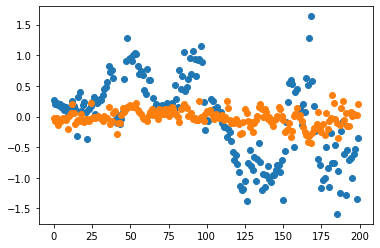

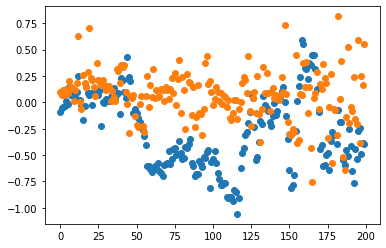

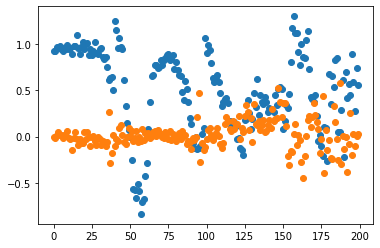

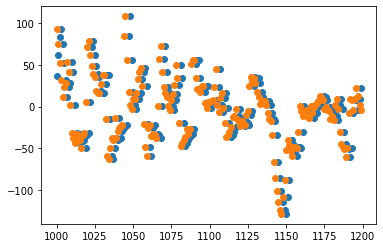

In [76]:
#raw:yaw, pitch, roll,x,y,z
#raw:x,y,z,yaw, pitch, roll

plt.scatter(range(0,200),raw[0:200,3])
plt.scatter(range(0,200),proc[0:200,0])

plt.figure()
plt.scatter(range(0,200),raw[0:200,4])
plt.scatter(range(0,200),proc[0:200,1])

plt.figure()
plt.scatter(range(0,200),raw[0:200,5])
plt.scatter(range(0,200),proc[0:200,2])


plt.figure()
plt.scatter(range(1000,1200),raw[1000:1200,0])
plt.scatter(range(1000,1200),proc[1000:1200,3])


In [3]:
def dfCompactor(df):
    df['Date']=df['Date'].astype(int)
    df['Time']=df['Time']*1000
    df['Time']=df['Time'].astype(int)
    df.rename(columns={"Time": "Time[ms]"})

    df['GyroX']=df['GyroX'].astype(float)
    df['GyroX']=df['GyroX']*1000*1000
    df['GyroX']=df['GyroX'].astype(int)
    df.rename(columns={"GyroX": "GyroX[microD/s]"})

    df['GyroY']=df['GyroY'].astype(float)
    df['GyroY']=df['GyroY']*1000*1000
    df['GyroY']=df['GyroY'].astype(int)
    df.rename(columns={"GyroY": "GyroY[microD/s]"})

    df['GyroZ']=df['GyroZ'].astype(float)
    df['GyroZ']=df['GyroZ']*1000*1000
    df['GyroZ']=df['GyroZ'].astype(int)
    df.rename(columns={"GyroZ": "GyroZ[microD/s]"})

    df['AccelX']=df['AccelX'].astype(float)
    df['AccelX']=df['AccelX']*1000*1000
    df['AccelX']=df['AccelX'].astype(int)
    df.rename(columns={"AccelX": "AccelX[microm/s2]"})

    df['AccelY']=df['AccelY'].astype(float)
    df['AccelY']=df['AccelY']*1000*1000
    df['AccelY']=df['AccelY'].astype(int)
    df.rename(columns={"AccelY": "AccelY[microm/s2]"})

    df['AccelZ']=df['AccelZ'].astype(float)
    df['AccelZ']=df['AccelZ']*1000*1000
    df['AccelZ']=df['AccelZ'].astype(int)
    df.rename(columns={"AccelZ": "AccelZ[microm/s2]"})

    return df

def dfOrganizer(df):
    df.columns.values[2]='TimeStamp'

    df.columns.values[8]='GyroX'
    df.columns.values[9]='GyroY'
    df.columns.values[10]='GyroZ'

    df.columns.values[11]='AccelX'
    df.columns.values[12]='AccelY'
    df.columns.values[13]='AccelZ'

    df = df.filter(['Name','TimeStamp','GyroX','GyroY','GyroZ','AccelX','AccelY','AccelZ'])
    df['TimeStamp'] = df['TimeStamp'].astype(float)
    df['TimeStamp']=df['TimeStamp']-1000*3600*4 #fixing the timezone

    df.insert(2,'Date',float('nan'))
    df.insert(3,'Time',float('nan'))

    df['Date']=pd.to_datetime(df['TimeStamp'],unit='ms')
    df['Time']=pd.to_datetime(df['TimeStamp'],unit='ms')
    df['Date']=df['Date'].dt.dayofyear
    df['Time']=df['Time'].dt.hour*3600+df['Time'].dt.minute*60+df['Time'].dt.second+df['Time'].dt.microsecond*0.001*0.001

    df.drop(columns=['TimeStamp'],inplace=True)
    return df

def csvReader(addressPrefix):
    dataFiles=[]
    for root, dirs, files in os.walk(addressPrefix, topdown=False):
       for name in files:
           if '.csv' in name:
               dataFiles.append([os.path.join(root,name)])
    for counter,element in enumerate(dataFiles):
        print(element)
        rows = []
        with open(element[0], 'r') as csvfile:
            csvreader = csv.reader(csvfile,delimiter = "\t")
            next(csvreader) #skipping the first junk line
            headers = next(csvreader) #column titles
            while '' in headers:
                headers.remove("")
            if len(headers)!=17:
                continue
            next(csvreader) #skipping the units
            for row in csvreader:
                rows.append(row)
        df = pd.DataFrame(rows,columns=headers)
        participantName=element[0]
        participantName=participantName[participantName.find('CSV1')+5:participantName.find('CSV1')+10]
        df.insert(0,'Name',participantName)

        df=dfOrganizer(df)
        df=dfCompactor(df)

        if counter==0:
            dfTotal=df
        else:
            frames=[dfTotal,df]
            dfTotal=pd.concat(frames)

        # if counter==1:
        #     break
    dfTotal.sort_values(by=['Name', 'Date','Time'],inplace=True)
    return dfTotal

def preProcessor(dfTotal,R):
    columns=dfTotal.columns.values
    names=dfTotal['Name'].tolist()
    names=list(set(names))

    dfProc=pd.DataFrame([],columns=columns)
    for counter,name in enumerate(names):
        print(name, (counter+1)/len(names))
        df=dfTotal[dfTotal['Name']==name]
        for column in columns:
            if column!='Time' and column!='Date' and column!='Name':
                df[column]=list(gaussian_filter1d(df[column].tolist(),sigma=R))
            df['GyroX']=df['GyroX'].astype(float)

        df['GyroX']=df['GyroX'].astype(int)
        df['GyroY']=df['GyroY'].astype(int)
        df['GyroZ']=df['GyroZ'].astype(int)
        df['AccelX']=df['AccelX'].astype(int)
        df['AccelY']=df['AccelY'].astype(int)
        df['AccelZ']=df['AccelZ'].astype(int)

        frames=[dfProc,df]
        dfProc=pd.concat(frames)
        nameIndex = dfTotal[(dfTotal.Name == name)].index
        dfTotal.drop(nameIndex,inplace=True)
    return dfProc

def funcCaller(addressPrefix):
    if os.path.exists(os.path.join(addressPrefix,'RawData.csv')):
        dfRaw=pd.read_csv(os.path.join(addressPrefix,'RawData.csv'))
    else:
        dfRaw=csvReader(os.path.join(addressPrefix,'CSV1'))
        dfRaw.to_csv(os.path.join(addressPrefix,'RawData.csv'),index=False)
    names=dfRaw['Name'].tolist()
    names=list(set(names))
    print('Total particpant number=',len(names))

    if os.path.exists(os.path.join(addressPrefix,'FilteredData.csv')):
        dfProcessed=pd.read_csv(os.path.join(addressPrefix,'FilteredData.csv'))
    else:
        dfProcessed=preProcessor(dfRaw,R=3)
        dfProcessed.to_csv(os.path.join(addressPrefix,'FilteredData.csv'),index=False)
    return dfProcessed

dfTotal=funcCaller(addressPrefix)

['C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/CSV1\\P2001\\data\\csv\\P105_10_30_Session1_P105_10_30_Calibrated.csv']
['C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/CSV1\\P2011\\data\\fcsv\\P011_09_15_Session2_P011_9_15_Calibrated.csv']
['C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/CSV1\\P2012\\data\\csv\\P012_10_06_Session1_P012_10_06_Calibrated.csv']
['C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/CSV1\\P2013\\data\\csv\\P013_10_14_Session1_P013_10_14_Calibrated.csv']
['C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/CSV1\\P2014\\data\\csv\\P014_09_15_Session1_P014_09_15_Calibrated.csv']
['C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/CSV1\\P2015\\data\\csv\\P015_10_22_Session1_P015_10_22_Calibrated.csv']
['C:

In [8]:
def shimmerReader(addressPrefix):
    dataFiles=[]
    for root, dirs, files in os.walk(addressPrefix, topdown=False):
       for name in files:
           if '.shm' in name:
               dataFiles.append([os.path.join(root,name),name])
    sensorData=[]
    for iteration,element in enumerate(dataFiles):
        print((iteration+1)/len(dataFiles))
        nameTemp=element[1]
        nameTemp=nameTemp[:nameTemp.find('.shm')]
        with open(element[0], mode='rb') as txtfile:
            fileData = txtfile.read()
            tempList=[]
            for counter in range(int(len(fileData)/4)):
                if counter%6==0 and counter!=0:
                    tempList.append(nameTemp)
                    sensorData.append(tempList)
                    tempList=[]
                tempVal=fileData[counter*4:(counter+1)*4]
                tempVal=struct.unpack('f',tempVal)
                tempVal=tempVal[0]
                tempList.append(tempVal)
        txtfile.close()
        if iteration==3:
            break
    dfSensor=pd.DataFrame(sensorData,columns=[ 'X','Y','Z','Yaw','Pitch','Roll','Name'])
    dfSensor=dfSensor[['Name','X','Y','Z','Yaw','Pitch','Roll']]

    return dfSensor


def pdFromatter(df):
    df['Start'] = pd.to_datetime(df['Start'],format= '%H:%M:%S',errors='coerce')
    df = df[df['Start'].notna()]
    df['Start']=df['Start'].dt.hour*3600*1000+df['Start'].dt.minute*60*1000+df['Start'].dt.second*1000

    df['End'] = pd.to_datetime(df['End'],format= '%H:%M:%S',errors='coerce')
    df = df[df['End'].notna()]
    df['End']=df['End'].dt.hour*3600*1000+df['End'].dt.minute*60*1000+df['End'].dt.second*1000
    df.sort_values(by=['Name', 'Start','End'],inplace=True)

    return df

def labelReader(addressPrefix):
    dataFiles=[]
    for root, dirs, files in os.walk(addressPrefix, topdown=False):
       for name in files:
           if '.txt' in name:
               dataFiles.append([os.path.join(root,name),name])
    mealTime=[]
    sensorTiming=[]
    for element in dataFiles:
        nameTemp=element[1]
        nameTemp=nameTemp[:nameTemp.find('-events')]
        with open(element[0], 'r+') as txtfile:
            fileData = txtfile.read()
            fileData=fileData.splitlines()
            while '' in fileData:
                fileData.remove('')
            tempStart=fileData[0]
            tempStart=tempStart.split()
            tempStart=tempStart[2]

            tempEnd=fileData[-1]
            tempEnd=tempEnd.split()
            tempEnd=tempEnd[2]

            sensorTiming.append([nameTemp,tempStart,tempEnd])
            for counter in range(1,len(fileData)-1):
                tempStr=fileData[counter]
                tempStr=tempStr.split()
                mealTime.append([nameTemp,tempStr[1],tempStr[2]])

    dfMeal=pd.DataFrame(mealTime,columns=['Name','Start','End'])
    dfMeal=pdFromatter(dfMeal)

    dfSensor=pd.DataFrame(sensorTiming,columns=['Name','Start','End'])
    dfSensor=pdFromatter(dfSensor)

    return dfMeal,dfSensor

def featureExtractor(df):
    windowLength=30*1000
    featureData=[]
    names=df['Name'].tolist()
    names=list(set(names))
    for name in names:
        dfName=df[df['Name']==name]
        startTime=dfName['Time'].min()
        endTime=startTime+windowLength
        while startTime<24*3600*1000:
            dfTemp=dfName[dfName['Time']>=startTime]
            dfTemp=dfTemp[dfTemp['Time']<endTime]
            if len(dfTemp)>5:
                f2=abs(dfTemp['X'].values)+abs(dfTemp['Y'].values)+abs(dfTemp['Z'].values)
                f1=abs(dfTemp['Yaw'].values)+abs(dfTemp['Roll'].values)+abs(dfTemp['Pitch'].values)
                f1=f1/f2
                f1=np.mean(f1)
                f2=np.mean(f2)
                featureData.append([name,startTime,endTime,f1,f2])
            startTime+=windowLength
            endTime+=windowLength
        break
    return featureData

def timeFinder(dfData,dfTime):
    names=dfData['Name'].tolist()
    names=list(set(names))
    dfData.insert(1,'Time',float('nan'))
    for name in names:
        dfTemp=dfTime[dfTime['Name']==name]
        if len(dfTemp)>1:
            warnings.warn('More than one event file for:'+name)
            break
        elif len(dfTemp)==0:
            warnings.warn('No event file for:'+name)
            break
        startTemp=dfTemp['Start'].tolist()
        endTemp=dfTemp['End'].tolist()
        indices = dfSensor[dfSensor['Name']==name].index.tolist()
        tempTimeStamp=np.linspace(startTemp,endTemp,num=len(indices))
        dfData.loc[indices,'Time']=tempTimeStamp
    return dfData

def labelExtractor(dfLabel,features):
    dataTotal=[]
    for feature in features:
        windowName=feature[0]
        windowStart=feature[1]
        windowEnd=feature[2]
        f1=feature[3]
        f2=feature[4]
        dfTemp=dfLabel[dfLabel['Name']==windowName]
        if len(dfTemp)==0:
            print('skipped',windowName)
            continue
        eatingFlag=False
        for counter in range(0,len(dfTemp)):
            if dfTemp.iloc[counter,1]<windowEnd and dfTemp.iloc[counter,2]>windowStart:
                eatingFlag=True
                break
        dataTotal.append([f1,f2,eatingFlag])
    dataTotal=np.asarray(dataTotal)
    return dataTotal

dfSensor=shimmerReader(os.path.join(addressPrefix,'SHMfiles'))
dfLabel,dfTiming=labelReader(os.path.join(addressPrefix,'EVENTfiles'))
dfSensor=timeFinder(dfSensor,dfTiming)
featureData=featureExtractor(dfSensor)
data=labelExtractor(dfLabel,featureData)
print(data)

0.002824858757062147
0.005649717514124294
0.00847457627118644
0.011299435028248588
[[3.46367482e+02 3.79127031e-01 0.00000000e+00]
 [3.66672894e+02 8.09884131e-01 0.00000000e+00]
 [4.46802625e+02 3.36390916e-01 0.00000000e+00]
 ...
 [4.30557106e+02 3.46795479e-01 0.00000000e+00]
 [1.35284319e+02 4.35813654e-02 0.00000000e+00]
 [2.86486112e+02 7.17969256e-02 0.00000000e+00]]


In [ ]:
def XGClassifier(dataList, labelList,randomSeed):
    trainData, testData, trainLabels, testLabels = train_test_split(dataList, labelList, test_size=0.25,random_state=randomSeed)
    trainData, valData, trainLabels, valLabels = train_test_split(trainData, trainLabels, test_size=0.33,random_state=randomSeed)
    accuracyBest=0
    for maxDepth in np.arange(3,30):
        for estimator in np.arange(5,50,2):
            clf = xgb.XGBClassifier(n_estimators=estimator,max_depth=maxDepth,objective = "binary:logistic",
                                    eval_metric = "logloss",use_label_encoder =False,scale_pos_weight=20)
            clf.fit(trainData, trainLabels)
            slidingWindowPrediction = clf.predict_proba(valData)
            slidingWindowPrediction=slidingWindowPrediction[:,1]
            slidingWindowPrediction[slidingWindowPrediction>=0.5]=1
            slidingWindowPrediction[slidingWindowPrediction<0.5]=0

            confMatrix=sklearn.metrics.confusion_matrix(valLabels,slidingWindowPrediction)
            accuracy=sklearn.metrics.accuracy_score(valLabels,slidingWindowPrediction)
            recall=sklearn.metrics.recall_score(valLabels,slidingWindowPrediction)
            precision=sklearn.metrics.precision_score(valLabels,slidingWindowPrediction)

            if accuracy>accuracyBest:
                confMatrixBest=confMatrix
                accuracyBest=accuracy
                modelBest=clf
                recallBest=recall
                precisionBest=precision
    print('Testing on validation dataset:')
    print(confMatrixBest)
    print('Accuracy',np.round(100*accuracyBest,0),'Recall',np.round(100*recallBest,0),'Precision',np.round(100*precisionBest,0))

    slidingWindowPrediction = modelBest.predict_proba(testData)
    slidingWindowPrediction=slidingWindowPrediction[:,1]
    slidingWindowPrediction[slidingWindowPrediction>=0.5]=1
    slidingWindowPrediction[slidingWindowPrediction<0.5]=0

    confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
    accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)
    recall=sklearn.metrics.recall_score(testLabels,slidingWindowPrediction)
    precision=sklearn.metrics.precision_score(testLabels,slidingWindowPrediction)

    print('Testing on validation dataset:')
    print(confMatrix)
    print('Accuracy',np.round(100*accuracy,0),'Recall',np.round(100*recall,0),'Precision',np.round(100*precision,0))

allData=data[:,0:2]
allLabel=data[:,2]
XGClassifier(allData, allLabel,randomSeed=53)